**This notebook is not to be taken as financial advice. I am not a qualified professional, so this notebook is only meant to be used for educational/entertainment purposes. Investing/trading can lead to losses.**

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display
from importlib import reload
import matplotlib.pyplot as plt


from typing import List, Tuple
from functools import cache  # Python 3.9 required
import sys
sys.path.append('..')

import yfinance as yf

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 9

In [198]:
# replicate the birthday rule backtest
import lc_investing.birthday_rule
lc_investing.birthday_rule = reload(lc_investing.birthday_rule)

s1 = lc_investing.birthday_rule.Simulation(data_folder='../lc_investing/data/')
s1.retirement_savings_before_period.head(2)
s1.retirement_savings_before_period.Final.describe()

count    9.600000e+01
mean     6.465746e+05
std      1.686988e+05
min      2.903095e+05
25%      5.393432e+05
50%      6.415549e+05
75%      7.790439e+05
max      1.026903e+06
Name: Final, dtype: float64

In [199]:
data = s1.monthly_data.loc[:, ['Months_beginning_Jan_1871', 'Monthly_years', 'One_plus_monthly_real_stock_rate']]
data = data.loc[0:1661]

In [200]:
s1.monthly_data.head()

,Months_beginning_Jan_1871,Monthly_years,Monthly_nom_gov_bond_rate,Monthly_nom_margin_rate,Monthly_nom_stock_return,Monthly_CPI,Fed_funds_rate,Monthly_CPI_lead1,yearly_annual_margin_rate,Prospective_monthly_inflation_rate,...,Annualized_adjusted_stock_return,Stock_Return_If_Margin_Call,Monthly_real_gov_bond_rate,Monthly_real_margin_rate,Monthly_real_stock_rate,Log_Annualized_adjusted_stock_return,Margin_Call_Cutoff,Margin_Call_Real_Stock_Return,One_plus_monthly_real_stock_rate,One_plus_monthly_real_gov_bond_rate
0,1.0,1871.01,0.012089,0.005254,0.018393,12.464061,NaN,12.844641,0.063046,1.030534,...,1.244477,1.0,-0.017899,-0.024531,-0.011781,0.218715,3.0,-0.029629,0.988219,0.982101
1,2.0,1871.02,0.009599,0.003378,0.029259,12.844641,NaN,13.034972,0.040538,1.014818,...,1.413505,1.0,-0.005142,-0.011273,0.014230,0.346073,3.0,-0.014602,1.014230,0.994858
2,3.0,1871.03,0.008997,0.003434,0.032899,13.034972,NaN,12.559226,0.041213,0.963502,...,1.474677,1.0,0.047218,0.041445,0.072026,0.388439,3.0,0.037880,1.072026,1.047218
3,4.0,1871.04,0.005716,0.004741,0.029887,12.559226,NaN,12.273812,0.056893,0.977274,...,1.423893,1.0,0.029103,0.028105,0.053836,0.353395,3.0,0.023254,1.053836,1.029103
4,5.0,1871.05,0.005903,0.002911,-0.003772,12.273812,NaN,12.083481,0.034935,0.984493,...,0.955660,1.0,0.021747,0.018708,0.011920,-0.045353,3.0,0.015751,1.011920,1.021747


In [7]:
data.tail()

,Months_beginning_Jan_1871,Monthly_years,One_plus_monthly_real_stock_rate
1657,1658.0,2009.02,0.938458
1658,1659.0,2009.03,1.120492
1659,1660.0,2009.04,1.063996
1660,1661.0,2009.05,1.025170
1661,1662.0,2009.06,0.972866


In [132]:
start=0
end=5

end_dates = np.arange(data.index.values[-1], 44, -1)
start_dates = end_dates - 44
t_list = np.arange(1,45)
returns_list = []

C = np.repeat(data.loc[:, 'One_plus_monthly_real_stock_rate'].values.reshape(-1,1), 45, axis=1)
C.shape

(1662, 45)

In [134]:
C[-5:, -5:]

array([[0.93845806, 0.93845806, 0.93845806, 0.93845806, 0.93845806],
       [1.12049165, 1.12049165, 1.12049165, 1.12049165, 1.12049165],
       [1.0639958 , 1.0639958 , 1.0639958 , 1.0639958 , 1.0639958 ],
       [1.02517038, 1.02517038, 1.02517038, 1.02517038, 1.02517038],
       [0.97286619, 0.97286619, 0.97286619, 0.97286619, 0.97286619]])

In [127]:
data.tail()

,Months_beginning_Jan_1871,Monthly_years,One_plus_monthly_real_stock_rate
1657,1658.0,2009.02,0.938458
1658,1659.0,2009.03,1.120492
1659,1660.0,2009.04,1.063996
1660,1661.0,2009.05,1.025170
1661,1662.0,2009.06,0.972866


In [411]:
data1=data.copy()#.tail()

numerator = np.repeat(data1.loc[:,['One_plus_monthly_real_stock_rate']].values.reshape(1,-1), data1.shape[0], axis=0)
# numerator

In [488]:
from copy import deepcopy
d = deepcopy(numerator)

for col in range(1,d.shape[0]):
    d[col,:]=np.roll(d[col,:], shift=-col, axis=0)

d2 = np.flip(d, axis=0)
d2[np.triu_indices(d2.shape[0], 1)]=1
d2 = np.concatenate((np.ones((d2.shape[0], 1)), d2), axis=1)

R = np.cumprod(d2, axis=1)
R[np.triu_indices(R.shape[0], 1)]=1

C = R[44:,0:45]
# rows represent start dates
# columns are n-period returns. E.g. the 2nd column is the 1-period return
# the 45-th column is the 44-period returns
# the columns can also represent prices that started at 1
print(C.shape)

(1618, 45)


In [500]:
d2[47:48, 0:45]

array([[1.        , 0.99799297, 0.99069115, 0.97180314, 1.04803383,
        1.02559374, 1.00699245, 0.99782107, 1.00927449, 0.99947988,
        0.98723464, 0.97102421, 1.00423077, 1.02091089, 1.03036502,
        1.04180717, 1.02153506, 1.01996409, 1.00386394, 1.01055365,
        0.96646079, 1.03507856, 1.02763792, 1.00150812, 1.0060021 ,
        0.95974882, 1.02791422, 1.02771729, 0.94631578, 1.01306164,
        0.92903021, 0.98150993, 0.96536565, 1.03615398, 1.01706148,
        0.94798137, 0.93430922, 1.02519749, 0.95284244, 0.80620792,
        0.93179305, 1.01633366, 0.97986571, 0.92893152, 0.93845806]])

In [501]:
R[47:48, 0:45]

array([[1.        , 0.99799297, 0.98870281, 0.9608245 , 1.00697658,
        1.03274887, 1.03997032, 1.0377043 , 1.04732847, 1.04678373,
        1.03342116, 1.00347697, 1.00772246, 1.02879483, 1.0600342 ,
        1.10435124, 1.12813351, 1.15065568, 1.15510174, 1.16729228,
        1.12814222, 1.16771583, 1.19998907, 1.20179879, 1.20901211,
        1.16034795, 1.19273816, 1.22579762, 1.15999164, 1.17514304,
        1.09174338, 1.07155697, 1.03444429, 1.07184357, 1.09013081,
        1.0334237 , 0.96553729, 0.9898664 , 0.94318672, 0.7604046 ,
        0.70853973, 0.72011278, 0.70561382, 0.65546691, 0.6151282 ]])

In [499]:
0.98164307 * 0.80620792

0.7914084176471143

In [472]:
d3.shape

(1662, 1663)

In [506]:
sigma=np.cov(C.T)
sigma[:5,:5]

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00171126, 0.00220427, 0.00219728, 0.00211476],
       [0.        , 0.00220427, 0.00445705, 0.00495098, 0.00486319],
       [0.        , 0.00219728, 0.00495098, 0.0071953 , 0.00759284],
       [0.        , 0.00211476, 0.00486319, 0.00759284, 0.00971765]])

In [502]:
df = pd.DataFrame(C, columns=[str(i) + 'per' for i in range(C.shape[1])])
print(df.shape)
df.head()

(1618, 45)


,0per,1per,2per,3per,4per,5per,6per,7per,8per,9per,...,35per,36per,37per,38per,39per,40per,41per,42per,43per,44per
0,1.0,1.048034,1.074857,1.082373,1.080014,1.090031,1.089464,1.075557,1.044392,1.048810,...,0.981643,0.791408,0.737429,0.749474,0.734384,0.682192,0.640209,0.717349,0.763256,0.782467
1,1.0,0.971803,1.018483,1.044549,1.051853,1.049561,1.059296,1.058745,1.045229,1.014943,...,1.001177,0.953964,0.769093,0.716636,0.728341,0.713676,0.662956,0.622157,0.697122,0.741734
2,1.0,0.990691,0.962757,1.009002,1.034826,1.042062,1.039791,1.049435,1.048889,1.035499,...,0.967479,0.991857,0.945084,0.761934,0.709965,0.721561,0.707033,0.656785,0.616365,0.690632
3,1.0,0.997993,0.988703,0.960824,1.006977,1.032749,1.039970,1.037704,1.047328,1.046784,...,1.033424,0.965537,0.989866,0.943187,0.760405,0.708540,0.720113,0.705614,0.655467,0.615128
4,1.0,1.013389,1.011355,1.001940,0.973689,1.020459,1.046576,1.053894,1.051598,1.061351,...,1.104726,1.047260,0.978465,1.003119,0.955815,0.770585,0.718026,0.729754,0.715061,0.664243


In [503]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()

In [582]:
S

,0per,1per,2per,3per,4per,5per,6per,7per,8per,9per,...,35per,36per,37per,38per,39per,40per,41per,42per,43per,44per
0per,0.01311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1per,0.00000,0.622642,0.417084,0.331752,0.271331,0.275498,0.317166,0.316542,0.298877,0.304243,...,0.279775,0.300988,0.312260,0.301790,0.301169,0.310244,0.305493,0.292035,0.304603,0.302254
2per,0.00000,0.417084,0.860361,0.552754,0.425085,0.360782,0.413404,0.438029,0.429747,0.421865,...,0.388120,0.391258,0.433399,0.428608,0.417046,0.426387,0.430926,0.416287,0.416968,0.423276
3per,0.00000,0.331752,0.552754,0.890731,0.537742,0.413549,0.397568,0.426914,0.447330,0.452732,...,0.425432,0.401835,0.421562,0.448900,0.444131,0.442533,0.443181,0.439999,0.443208,0.436906
4per,0.00000,0.271331,0.425085,0.537742,0.821536,0.478299,0.402932,0.368629,0.397297,0.423661,...,0.399721,0.391336,0.385416,0.390712,0.417421,0.424261,0.418442,0.406329,0.420391,0.417105
5per,0.00000,0.275498,0.360782,0.413549,0.478299,0.782256,0.476679,0.374903,0.337719,0.374608,...,0.372274,0.370583,0.381643,0.364477,0.369429,0.404274,0.403833,0.385155,0.393199,0.400389
6per,0.00000,0.317166,0.413404,0.397568,0.402932,0.476679,0.818286,0.494957,0.383562,0.356243,...,0.396773,0.386287,0.400452,0.400381,0.379869,0.399108,0.426796,0.417634,0.417537,0.417577
7per,0.00000,0.316542,0.438029,0.426914,0.368629,0.374903,0.494957,0.813000,0.487647,0.390426,...,0.378496,0.394482,0.399043,0.399565,0.397881,0.392931,0.400315,0.421251,0.428284,0.418770
8per,0.00000,0.298877,0.429747,0.447330,0.397297,0.337719,0.383562,0.487647,0.801932,0.491906,...,0.371035,0.371615,0.405285,0.393163,0.394587,0.401295,0.388800,0.387086,0.423480,0.421755
9per,0.00000,0.304243,0.421865,0.452732,0.423661,0.374608,0.356243,0.390426,0.491906,0.831424,...,0.363852,0.377088,0.394544,0.413227,0.401971,0.409011,0.415036,0.391103,0.402790,0.431497


In [583]:
mu_1 = (0.07/12)
mu_2 = np.exp(mu_1 * np.arange(1,45))

sigma_1 = 0.4/12 #0.2/12

S_2 = np.diag(np.ones(44))

for row in range(S_2.shape[0]):
    t=row+1
    for col in range(S_2.shape[0]):
        s=col+1
        if s<t:
            S_2[row, col] = np.exp(2*mu_1*(t+s)) * (np.exp(s*sigma_1**2) - 1)
        elif s>t:
            S_2[row, col] = np.exp(2*mu_1*(t+s)) * (np.exp(t*sigma_1**2) - 1)
        else:
            S_2[row, col] = np.exp(2*mu_1*(t+s)) * (np.exp(s*sigma_1**2) - 1)
S_2.shape

(44, 44)

In [584]:
S_2[0:5, :5]

array([[0.00113797, 0.00115133, 0.00116484, 0.00117851, 0.00119234],
       [0.00115133, 0.00233097, 0.00235833, 0.002386  , 0.002414  ],
       [0.00116484, 0.00235833, 0.00358099, 0.00362302, 0.00366553],
       [0.00117851, 0.002386  , 0.00362302, 0.00489009, 0.00494748],
       [0.00119234, 0.002414  , 0.00366553, 0.00494748, 0.0062604 ]])

In [585]:
print(mu.shape)
print(sigma.shape)

(45,)
(45, 45)


In [586]:
np.diag(S)

array([0.01311011, 0.62264212, 0.8603611 , 0.89073119, 0.82153644,
       0.78225552, 0.81828574, 0.81300027, 0.8019323 , 0.83142369,
       0.82595053, 0.84199374, 0.87611513, 0.89395414, 0.93728938,
       0.91761549, 0.85040148, 0.81200397, 0.82268892, 0.91380123,
       0.93518334, 0.9419874 , 0.88260788, 0.85467937, 0.85904114,
       0.87596748, 0.89264006, 0.86737838, 0.87247079, 0.84738652,
       0.86182267, 0.86383564, 0.84116959, 0.85293433, 0.8583887 ,
       0.82288598, 0.8259256 , 0.85642292, 0.85771597, 0.86208821,
       0.87709522, 0.88931921, 0.86836748, 0.89081927, 0.89948737])

In [587]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu_2, S_2, weight_bounds=(-1,10))
weights = ef.max_sharpe()

In [588]:
cleaned_weights = ef.clean_weights()

weights_list = [value for key, value in cleaned_weights.items()]
asset_list = [key for key, value in cleaned_weights.items()]

# for key, value in cleaned_weights.items():
#     print(key, value)
# print(cleaned_weights)

weights_df = pd.DataFrame({'asset': asset_list, 'weights_list': weights_list})

In [589]:
weights_df.head()

,asset,weights_list
0,0,1.00371
1,1,0.00000
2,2,0.00000
3,3,0.00000
4,4,0.00000


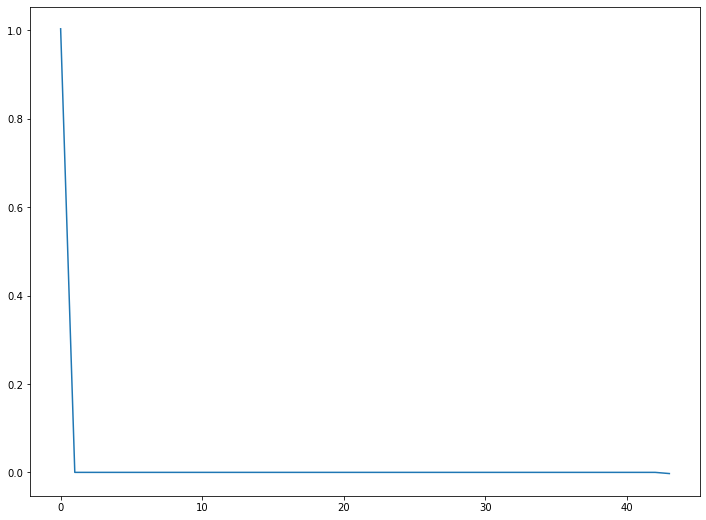

In [576]:
weights_df.weights_list.plot();

In [577]:
ef.portfolio_performance(verbose=True)

Expected annual return: 100.5%
Annual volatility: 1.7%
Sharpe Ratio: 58.49


(1.0049604137216606, 0.016838872631089834, 58.49325161490414)

In [3]:
TREASURY_BILL_RATE = 0.11  #%, Jan 2021
TRADING_DAYS_PER_YEAR = 250

In [4]:
# Needed for type hinting
class Asset:
  pass


def get_log_period_returns(price_history: pd.DataFrame):
  """Log of one-day prior"""
  close = price_history['Close'].values  
  return np.log(close[1:] / close[:-1]).reshape(-1, 1)


# daily_price_history has to at least have a column, called 'Close'
class Asset:
  def __init__(self, name: str, daily_price_history: pd.DataFrame):
    self.name = name
    self.daily_returns = get_log_period_returns(daily_price_history)
    self.expected_daily_return = np.mean(self.daily_returns)
  
  @property
  def expected_return(self):
    return TRADING_DAYS_PER_YEAR * self.expected_daily_return

  def __repr__(self):
    return f'<Asset name={self.name}, expected return={self.expected_return}>'

  @staticmethod
  @cache
  def covariance_matrix(assets: Tuple[Asset]):  # tuple for hashing in the cache
    product_expectation = np.zeros((len(assets), len(assets)))
    for i in range(len(assets)):
      for j in range(len(assets)):
        if i == j:
          product_expectation[i][j] = np.mean(assets[i].daily_returns * assets[j].daily_returns)
        else:
          product_expectation[i][j] = np.mean(assets[i].daily_returns @ assets[j].daily_returns.T)
    
    product_expectation *= (TRADING_DAYS_PER_YEAR - 1) ** 2

    expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    product_of_expectations = expected_returns @ expected_returns.T

    return product_expectation - product_of_expectations


def random_weights(weight_count, low=0.0, high=1.0):
    weights = np.random.uniform(low=low, high=high, size=(weight_count, 1))
    weights /= np.sum(weights)
    return weights.reshape(-1, 1)


class Portfolio:
  def __init__(self, assets: Tuple[Asset]):
    self.assets = assets
    self.asset_expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    self.covariance_matrix = Asset.covariance_matrix(assets)
    self.weights = random_weights(len(assets), low=0.0, high=1.0)
    
  def unsafe_optimize_with_risk_tolerance(self, risk_tolerance: float):
    res = minimize(
      lambda w: self._variance(w) - risk_tolerance * self._expected_return(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(-1., 2.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)
  
  def optimize_with_risk_tolerance(self, risk_tolerance: float):
    assert risk_tolerance >= 0.
    return self.unsafe_optimize_with_risk_tolerance(risk_tolerance)
  
  def optimize_with_expected_return(self, expected_portfolio_return: float):
    res = minimize(
      lambda w: self._variance(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
        {'type': 'eq', 'fun': lambda w: self._expected_return(w) - expected_portfolio_return},
      ],
      bounds=[(-1., 2.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def optimize_sharpe_ratio(self):
    # Maximize Sharpe ratio = minimize minus Sharpe ratio
    res = minimize(
      lambda w: -(self._expected_return(w) - TREASURY_BILL_RATE / 100) / np.sqrt(self._variance(w)),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(-1., 2.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def _expected_return(self, w):
    return (self.asset_expected_returns.T @ w.reshape(-1, 1))[0][0]
  
  def _variance(self, w):
    return (w.reshape(-1, 1).T @ self.covariance_matrix @ w.reshape(-1, 1))[0][0]

  @property
  def expected_return(self):
    return self._expected_return(self.weights)
  
  @property
  def variance(self):
    return self._variance(self.weights)

  def __repr__(self):
    return f'<Portfolio assets={[asset.name for asset in self.assets]}, expected return={self.expected_return}, variance={self.variance}>'

In [5]:
def yf_retrieve_data(tickers: List[str]):
  """Retrive price data from Yahoo Finance"""
  dataframes = []

  for ticker_name in tickers:
    ticker = yf.Ticker(ticker_name)
    history = ticker.history(period='10y')

    if history.isnull().any(axis=1).iloc[0]:  # the first row can have NaNs
      history = history.iloc[1:]
  
    assert not history.isnull().any(axis=None), f'history has NaNs in {ticker_name}'
    dataframes.append(history)
  
  return dataframes

## Usage example

In [6]:
# ITOT - US
# VNQ - REITs
# SGOV - T-bills
# VEA - developed markets, ex US
# VWO - emerging markets
stocks = ['ITOT', 'VNQ', 'VEA', 'VWO','SGOV'] 
# stocks = ['AAPL', 'AMZN', 'GOOG', 'BRK-B', 'JNJ', 'JPM']

daily_dataframes = yf_retrieve_data(stocks)
assets = tuple([Asset(name, daily_df) for name, daily_df in zip(stocks, daily_dataframes)])

print('      Exp. Ret.', 'SD')
for a in assets:
    print(a.name, ' ', round(a.expected_return, 3), '   ', round(np.std(a.daily_returns), 3))

      Exp. Ret. SD
ITOT   0.119     0.011
VNQ   0.07     0.013
VEA   0.052     0.011
VWO   0.019     0.013
SGOV   0.006     0.0


In [8]:
daily_dataframes[0].head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-12-14 00:00:00-05:00,26.720514,26.774252,26.666777,26.670908,34800,0.0,0.0
2012-12-17 00:00:00-05:00,26.782525,27.018148,26.774256,27.018148,55800,0.0,0.0


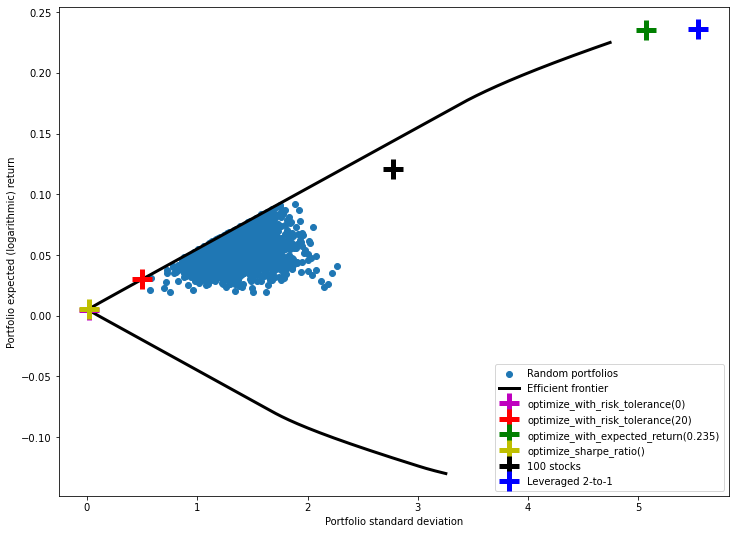

In [80]:
assets

X = []
y = []

# Drawing random portfolios
for i in range(3000):
  portfolio = Portfolio(assets)
  X.append(np.sqrt(portfolio.variance))
  y.append(portfolio.expected_return)

plt.scatter(X, y, label='Random portfolios')

# Drawing the efficient frontier
X = []
y = []
for rt in np.linspace(-300, 300, 1000):
  portfolio.unsafe_optimize_with_risk_tolerance(rt)
  X.append(np.sqrt(portfolio.variance))
  y.append(portfolio.expected_return)

plt.plot(X, y, 'k', linewidth=3, label='Efficient frontier')

# Drawing optimized portfolios
portfolio.optimize_with_risk_tolerance(0)
plt.plot(np.sqrt(portfolio.variance), 
         portfolio.expected_return, 
         'm+', 
         markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(0)')

portfolio.optimize_with_risk_tolerance(20)
plt.plot(np.sqrt(portfolio.variance), 
         portfolio.expected_return, 
         'r+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(20)')

portfolio.optimize_with_expected_return(0.235)
plt.plot(np.sqrt(portfolio.variance), 
         portfolio.expected_return, 
         'g+', markeredgewidth=5, markersize=20, label='optimize_with_expected_return(0.235)')

portfolio.optimize_sharpe_ratio()
plt.plot(np.sqrt(portfolio.variance), 
         portfolio.expected_return, 
         'y+', markeredgewidth=5, markersize=20, label='optimize_sharpe_ratio()')

portfolio = Portfolio(assets)
portfolio.weights = np.array([1,0,0,0,0])
plt.plot(np.sqrt(portfolio.variance), 
         portfolio.expected_return, 
         'k+', markeredgewidth=5, markersize=20, label='100 stocks')

portfolio = Portfolio(assets)
portfolio.weights = np.array([2,0,0,0,-1])
plt.plot(np.sqrt(portfolio.variance), 
         portfolio.expected_return, 
         'b+', markeredgewidth=5, markersize=20, label='Leveraged 2-to-1')

plt.xlabel('Portfolio standard deviation')
plt.ylabel('Portfolio expected (logarithmic) return')
plt.legend(loc='lower right')
plt.show()

In [56]:
pd.options.display.float_format = "{:,.5f}".format

In [61]:
portfolio = Portfolio(assets)
portfolio.optimize_with_risk_tolerance(0)
riskless_weights = portfolio.weights.flatten()

portfolio.optimize_with_risk_tolerance(20)
weights_risk_tolerance = portfolio.weights.flatten()

portfolio.optimize_with_expected_return(0.235)
weights_return = portfolio.weights.flatten()

portfolio.optimize_sharpe_ratio()
weights_sharpe = portfolio.weights.flatten()

display(
  pd.DataFrame(
    list(
      zip(
        [asset.name for asset in portfolio.assets],
        riskless_weights,
        weights_risk_tolerance,
        weights_return,
        weights_sharpe,
      )
    ),
    columns=[
      'asset',
      'optimize_with_risk_tolerance(0)',
      'optimize_with_risk_tolerance(20)',
      'optimize_with_expected_return(0.235)',
      'optimize_sharpe_ratio()',
    ],
  )
)

,asset,optimize_with_risk_tolerance(0),optimize_with_risk_tolerance(20),optimize_with_expected_return(0.235),optimize_sharpe_ratio()
0,ITOT,0.00006,0.15064,1.98938,0.00186
1,SGOV,0.99994,0.84936,-0.98938,0.99814
